# Assignment Part 1: Perceptron Template

This file will perform the following tasks:

- 1.1. Complete the implementation of the perceptron
- 1.2. Update the perceptron implementation to use full batch learning
- 1.3. Use the sigmoid activation function
- 1.4. Use multiple perceptrons to classify every dataset type
- 1.5. Print weights and Fashion MNIST data

### Perceptron Class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from matplotlib.pyplot import imshow

np.random.seed(42)  # Set seed for reproducibility
random.seed(42)  # Set seed for reproducibility

# 1.1. Complete the implementation of the perceptron
class Perceptron(object):
    
    # The init method is called when an object is created. It can be used to initialize the attributes of the class.
    def __init__(self, no_inputs, max_iterations=20, learning_rate=1e-1, activation="step"):
        self.no_inputs = no_inputs
        self.weights = np.random.randn(no_inputs + 1) * np.sqrt(1 / (no_inputs + 1)) # (Xavier initialisation)
        self.max_iter = max_iterations
        self.learning_rate = learning_rate
        self.activation = activation
        self.loss_tracker_train = []  # Store loss per epoch
        self.acc_tracker_train = []  # Store training accuracy per epoch
        self.acc_tracker_test = []  # Store test accuracy per epoch
    
    # Prints the details of the perceptron.
    def print_details(self):
        print("No. inputs:\t" + str(self.no_inputs))
        print("Max iterations:\t" + str(self.max_iter))
        print("Learning rate:\t" + str(self.learning_rate))

    # 1.3. Use the sigmoid activation function
    def activate_sigmoid(self, a):
        o = 1 / (1 + np.exp(-a))
        return o
    
    # Step activation
    def activate_step(self, a):
        o = 1 if a > 0 else 0
        return o
    
    # Performs feed-forward prediction on one set of inputs.
    def do_predict(self, x):
        x = np.concatenate((x, [1]))
        if self.activation == 'step':
            output = self.activate_step(np.matmul(self.weights, x))
        elif self.activation == 'sigmoid':
            output = self.activate_sigmoid(np.matmul(self.weights, x))
        return output

    # Computes training loss after each training epoch
    def compute_loss(self, X, labels):
        total_loss = 0
        for i in range(len(X)):
            o = self.do_predict(X[i])
            o = np.clip(o, 1e-9, 1 - 1e-9)  # Prevent log(0) by clipping values
            total_loss += -np.sum(labels[i] * np.log(o) + (1 - labels[i]) * np.log(1 - o))  # Cross-entropy loss
        return total_loss / len(X)
    
    # Compute accuracy
    def compute_accuracy(self, X, labels):
        y_pred = np.zeros(len(X))
        for i in range(len(X)):
            y_pred[i] = np.round(self.do_predict(X[i]))
        accuracy = np.mean(y_pred == labels)
        return accuracy

    # Trains the perceptron using labelled training data.
    def do_train_online(self, training_data, labels, test_data, test_labels, plot=True):
        assert len(training_data) == len(labels)

        print('> Training...')

        # Repeat for no. of epochs
        for _ in range(self.max_iter):

            # Shuffle input and label data
            indices = np.arange(len(training_data))
            np.random.shuffle(indices)
            training_data, labels = training_data[indices], labels[indices]

            # Feedforward and update weights based on error
            for i in range(len(training_data)):
                o = self.do_predict(training_data[i])
                x = np.concatenate((training_data[i], [1]))
                self.weights -= self.learning_rate * (o - labels[i]) * x

            if plot:
                self.loss_tracker_train.append(self.compute_loss(training_data, labels))  # Record train loss per epoch
                self.acc_tracker_train.append(self.compute_accuracy(training_data, labels))  # Record train accuracy per epoch
                self.acc_tracker_test.append(self.compute_accuracy(test_data, test_labels))  # Record test accuracy per epoch

        print('> Training completed.')

        return
    
    # 1.2. Update the perceptron implementation to use full batch learning
    def train_batch(self, training_data, labels, test_data, test_labels, plot=True):
        assert len(training_data) == len(labels)

        print('> Training...')

        # Feedforward, accumulate all weight-updates, update weights based on average of accumulated errors, and repeat for no. of epochs
        for _ in range(self.max_iter):
            weight_update = np.zeros(self.no_inputs + 1)
            for i in range(len(training_data)):
                o = self.do_predict(training_data[i])
                x = np.concatenate((training_data[i], [1]))
                weight_update += self.learning_rate * (o - labels[i]) * x
            self.weights -= weight_update / len(training_data)

            if plot:
                self.loss_tracker_train.append(self.compute_loss(training_data, labels))  # Record train loss per epoch
                self.acc_tracker_train.append(self.compute_accuracy(training_data, labels))  # Record train accuracy per epoch
                self.acc_tracker_test.append(self.compute_accuracy(test_data, test_labels))  # Record test accuracy per epoch
        
        print('> Training completed.')

        return

    # Tests the prediction on each element of the testing data. Prints the precision, recall, and accuracy of the perceptron.
    def test(self, testing_data, labels):
        assert len(testing_data) == len(labels)
        
        tp = 0 # true positive counter
        fp = 0 # false positive counter
        tn = 0 # true negative counter
        fn = 0 # false negative counter
        
        for i in range(len(testing_data)):
            o = np.round(self.do_predict(testing_data[i])) # Round sigmoid output to nearest class
            if o == 1 and labels[i] == 1:
                tp += 1
            elif o == 0 and labels[i] == 1:
                fn += 1
            elif o == 0 and labels[i] == 0:
                tn += 1
            elif o == 1 and labels[i] == 0:
                fp += 1
        cm = np.array([(tp, fp), (fn, tn)])  # Confusion matrix
        accuracy = (tp + tn) / len(testing_data)  # Accuracy
        precision = tp / (tp + fp)  # Precision
        recall = tp / (tp + fn)  # Recall

        self.confusion_matrix_plot(cm)
        print(f'Accuracy:\t{accuracy:.4f}')
        print(f'Precision:\t{precision:.4f}')
        print(f'Recall:\t\t{recall:.4f}')

    # Plot confusion matrix
    def confusion_matrix_plot(self, cm):
        plt.figure(figsize=(1.2, 1.2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=np.arange(2), yticklabels=np.arange(2))
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    # Weights visualiser (displays 28x28 image of the Perceptron's weights)
    def weights_visualiser(self):
        img = self.weights[:-1].reshape((28, 28))
        plt.imshow(img, cmap='viridis')

    # Plot loss and accuracy curves
    def plot_curves(self):
        fig = plt.figure(figsize=(13, 5))

        # Plot loss curve
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.loss_tracker_train) + 1), self.loss_tracker_train, linestyle='-', label="Training Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Cross-entropy Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.grid()

        # Plot accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.acc_tracker_train) + 1), self.acc_tracker_train, linestyle='-', label='Training Accuracy')
        plt.plot(range(1, len(self.acc_tracker_test) + 1), self.acc_tracker_test, linestyle='-', label='Testing Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()
        plt.grid()
        
        plt.show()

## 1.1. to 1.3. - Implementation of Perceptron (Binary Classification)

The following cells will train and analyse 4 perceptrons for a binary classification task. The fashion MNIST dataset is used for this task, with one class chosen as the target class '1', while the remaining 9 classes will be encoded as class '0'. For this analysis, Class 6 ('Shirts') was chosen as the target class.

Each of the 4 perceptrons will be trained over one of the below 4 combinations and analysed for the best results:
- activation: step, learning: online
- activation: step, learning: batch
- activation: sigmoid, learning: online
- activation: sigmoid, learning: batch.

### Load data:

In [243]:
print('Loading data...')

# Import data
train_data = np.loadtxt("mnist_fashion_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_fashion_test.csv", delimiter=",")

# Prepare train datasets
fac = 0.99 / 255

X_train = np.asarray(train_data[:, 1:], dtype=np.float64) * fac + 0.01
y_train = np.asarray(train_data[:, :1], dtype=np.float64).flatten()
y_train_bi = [None] * 10
for class_label in range(10):
    y_train_bi[class_label] = np.where(y_train == class_label, 1, 0)  # Convert labels to binary

# Prepare test datasets
X_test = np.asarray(test_data[:, 1:], dtype=np.float64) * fac + 0.01
y_test = np.asarray(test_data[:, :1], dtype=np.float64).flatten()
y_test_bi = [None] * 10
for class_label in range(10):
    y_test_bi[class_label] = np.where(y_test == class_label, 1, 0)  # Convert labels to binary

print('Data loaded.')

Loading data...
Data loaded.


### Training Phase:

(1) Step & Online

In [244]:
# Create and train perceptron
step_online = Perceptron(no_inputs=784, max_iterations=100, learning_rate=1e-6, activation='step')
step_online.do_train_online(X_train, y_train_bi[6], X_test, y_test_bi[6])

> Training...
> Training completed.


(2) Step & Batch

In [245]:
# Create and train perceptron
step_batch = Perceptron(no_inputs=784, max_iterations=300, learning_rate=5e-3, activation='step')
step_batch.train_batch(X_train, y_train_bi[6], X_test, y_test_bi[6])

> Training...
> Training completed.


(3) Sigmoid & Online

In [246]:
# Create and train perceptron
sigmoid_online = Perceptron(no_inputs=784, max_iterations=100, learning_rate=5e-4, activation='sigmoid')
sigmoid_online.do_train_online(X_train, y_train_bi[6], X_test, y_test_bi[6])

> Training...
> Training completed.


(4) Sigmoid & Batch

In [247]:
# Create and train perceptron
sigmoid_batch = Perceptron(no_inputs=784, max_iterations=300, learning_rate=1.8e-1, activation='sigmoid')
sigmoid_batch.train_batch(X_train, y_train_bi[6], X_test, y_test_bi[6])

> Training...
> Training completed.


### Testing Phase:

Activation: step, Learning: online


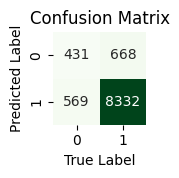

Accuracy:	0.8763
Precision:	0.3922
Recall:		0.4310
------------------------------------------
Activation: step, Learning: batch


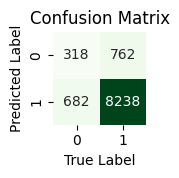

Accuracy:	0.8556
Precision:	0.2944
Recall:		0.3180
------------------------------------------
Activation: sigmoid, Learning: online


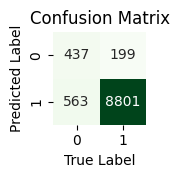

Accuracy:	0.9238
Precision:	0.6871
Recall:		0.4370
------------------------------------------
Activation: sigmoid, Learning: batch


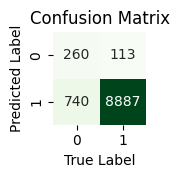

Accuracy:	0.9147
Precision:	0.6971
Recall:		0.2600


In [248]:
print('Activation: step, Learning: online')
step_online.test(X_test, y_test_bi[6])
print('------------------------------------------')

print('Activation: step, Learning: batch')
step_batch.test(X_test, y_test_bi[6])
print('------------------------------------------')

print('Activation: sigmoid, Learning: online')
sigmoid_online.test(X_test, y_test_bi[6])
print('------------------------------------------')

print('Activation: sigmoid, Learning: batch')
sigmoid_batch.test(X_test, y_test_bi[6])

Step/Online


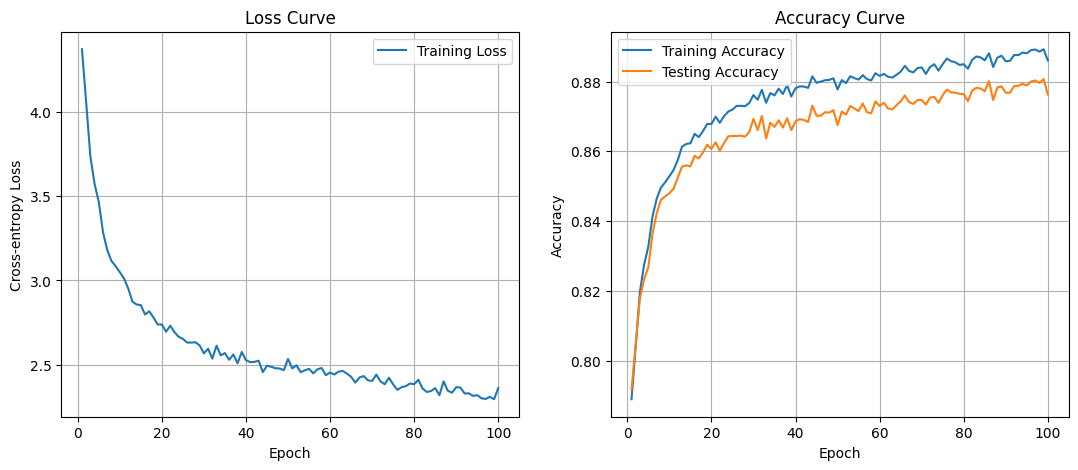

Step/Batch


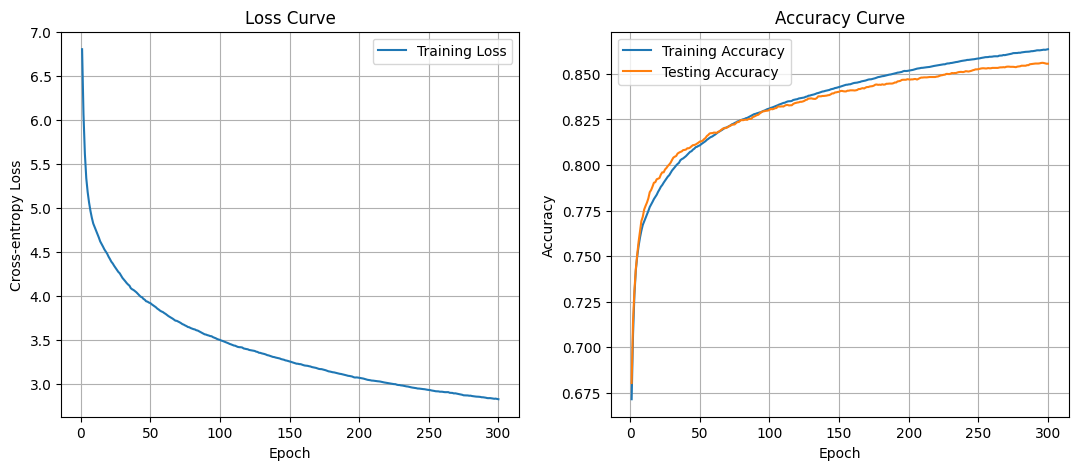

Sigmoid/Online


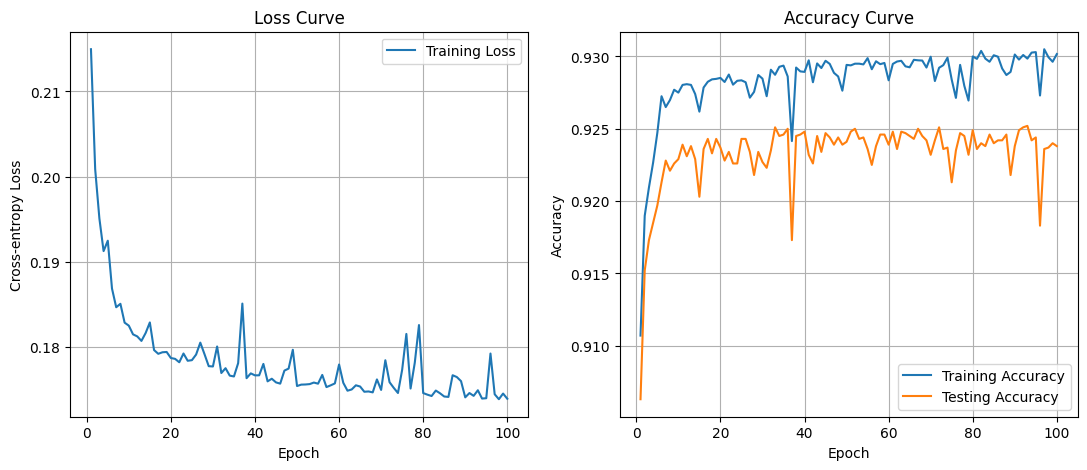

Sigmoid/Batch


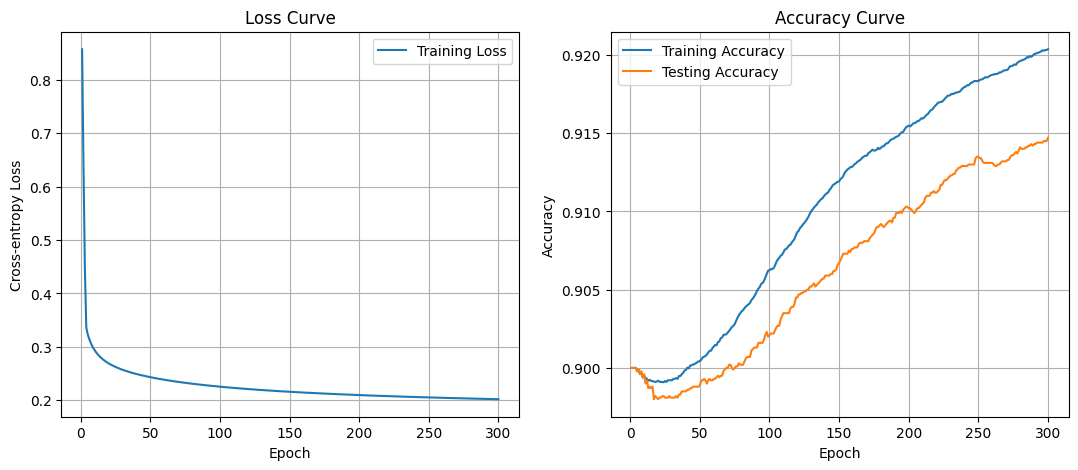

In [249]:
# Visualise loss and accuracy curves over epochs
print('Step/Online')
step_online.plot_curves()
print('Step/Batch')
step_batch.plot_curves()
print('Sigmoid/Online')
sigmoid_online.plot_curves()
print('Sigmoid/Batch')
sigmoid_batch.plot_curves()

### Analysis (Binary Classification - comparison between 4 perceptron combinations)
Results
- All models attained decent accuracy scores above 80%, with sigmoid generally performing better than step activation and online performing better than batch learning.
- This might be due to the way step function creates a hard decision boundary between the 2 classes for each pixel (weight), whereas sigmoid is able to output a confidence between 0 and 1. This allows the sigmoid perceptron to better classify more nuanced classes, and hence achieve a better accuracy score.
- However, the accuracy score alone is not enough to evaluate the training effectiveness, especially for a particularly imbalanced training dataset like this (10% from Class 6 and 90% from all other classes).
- The confusion matrices for all the perceptrons show a large proportion of misclassifications for the target class (low True Positives and high False negatives for Class 6 - Shirts). This is exceptionally so for the sigmoid/batch perceptron, which is affirmed by its extremely low recall score. Examining the confusion matrix for the sigmoid/batch perceptron, it appears that it could be exploiting the class imbalance of the training data by classifying all the data as the majority class, thereby achieving a high accuracy at the expense of recall.

Training convergence
- Loss and accuracy curves were plotted to determine the quality of the training convergences and the number of epochs it took. The loss function used was a binary cross-entropy loss, which is appropriate for binary classification tasks. The number of iterations were adjusted to allow the model more epochs to converge.
- A visual inspection of the curves reveal that the online training resulted in more erratic-looking loss and accuracy curves than those of full-batch training. This is due to how the weights are updated for each and every training example rather than for the entire training batch.
- Another observation is that the gradient descent for online training was faster than that of full-batch, achieving lower cross-entropy losses for the same number of epochs. This is because of the more frequent weight updates, which allows the training to converge more quickly at the start.
- The accuracy curve for sigmoid batch is unusual, as it starts from exactly 0.90 accuracy after the 1st epoch, before dipping further and then rising again.
- This might be because rather than converging towards a global minimum, the model had gotten stuck in a local minimum. Due to the class imbalance in the dataset, the perceptron could have initially tried to minimise its loss by classifying most of the data as 'not Class 6'.
- I have experimented using various learning rates to break out of the local minimum, and eventually settled on using 1.8e-1. If the learning rate were any lower, the model failed to escape the local minimum. Conversely, higher learning rates caused the training to become divergent rather than convergent.
- This issue might be rectifiable with a different initialisation. For example, under He initialisation the training escaped the local minimum by roughly 10 epochs earlier, and attained a marginally higher accuracy after 100 epochs. It also appears that bigger weight initialisations help the training to escape this local minimum faster.
- Additionally, this would be fixed by adjusting for the class imbalance in the training dataset.


 <i>(The above results will be referenced again in Part 2.4/2.5 comparison with neural network.)</i>

## 1.4. Use multiple perceptrons to classify every dataset type

The following cells will train and analyse 4 groups of 10 perceptrons each for a multi-class classification task. Each of the 10 perceptrons will be trained on a single class of the Fashion MNIST dataset, and together will be predict which one of the 10 classes a fashion item belongs to.

### Define training and testing functions for 10 perceptrons:

In [250]:
def train_all_perceptrons(perceptrons, data, labels, training='online'):
    for class_label in range(10):
        labels_binary = labels[class_label]  # Extract binary labels for selected class
        print(f'Training perceptron (Class {class_label})...')
        if training == 'online':
            perceptrons[class_label].do_train_online(data, labels_binary, _, _, plot=False)
        elif training == 'batch':
            perceptrons[class_label].train_batch(data, labels_binary, _, _, plot=False)
    print()
    return perceptrons

def confusion_matrix(predictions, labels):
    cm = np.zeros((10, 10), int)
    for i in range(len(predictions)):
        res = predictions[i]
        target = labels[i]
        cm[res, int(target)] += 1
    return cm

def confusion_matrix_plot(cm):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

def accuracy(confusion_matrix):
    sum_corrects = 0
    for i in range(len(confusion_matrix)):
        sum_corrects += confusion_matrix[i, i]
    return sum_corrects / confusion_matrix.sum()

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()

def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def test_all_perceptrons(perceptrons, data, labels):
    # Testing phase
    predictions = [None] * len(data)
    for i in range(len(data)):
        outputs = [perceptrons[c].do_predict(data[i]) for c in range(10)]
        predictions[i] = np.argmax(outputs)  # Pick the perceptron that has the highest confidence level

    # Print results
    cm = confusion_matrix(predictions, labels)
    confusion_matrix_plot(cm)
    print(f'Accuracy:\t{accuracy(cm):.4f}\n')
    for i in range(10):
        print(f'[Class {i}]\tPrecision: {precision(i, cm):.4f} | Recall: {recall(i, cm):.4f}')

### Training Phase:

(1) Step & Online

In [251]:
# Create and train 10 perceptrons (one per class)
step_online_multi = [Perceptron(no_inputs=784, max_iterations=50, learning_rate=1e-2, activation='step') for _ in range(10)]
step_online_multi = train_all_perceptrons(step_online_multi, X_train, y_train_bi, training='online')

Training perceptron (Class 0)...
> Training...
> Training completed.
Training perceptron (Class 1)...
> Training...
> Training completed.
Training perceptron (Class 2)...
> Training...
> Training completed.
Training perceptron (Class 3)...
> Training...
> Training completed.
Training perceptron (Class 4)...
> Training...
> Training completed.
Training perceptron (Class 5)...
> Training...
> Training completed.
Training perceptron (Class 6)...
> Training...
> Training completed.
Training perceptron (Class 7)...
> Training...
> Training completed.
Training perceptron (Class 8)...
> Training...
> Training completed.
Training perceptron (Class 9)...
> Training...
> Training completed.



(2) Step & Full-batch

In [252]:
# Create and train 10 perceptrons (one per class)
step_batch_multi = [Perceptron(no_inputs=784, max_iterations=50, learning_rate=5e-0, activation='step') for _ in range(10)]
step_batch_multi = train_all_perceptrons(step_batch_multi, X_train, y_train_bi, training='batch')

Training perceptron (Class 0)...
> Training...
> Training completed.
Training perceptron (Class 1)...
> Training...
> Training completed.
Training perceptron (Class 2)...
> Training...
> Training completed.
Training perceptron (Class 3)...
> Training...
> Training completed.
Training perceptron (Class 4)...
> Training...
> Training completed.
Training perceptron (Class 5)...
> Training...
> Training completed.
Training perceptron (Class 6)...
> Training...
> Training completed.
Training perceptron (Class 7)...
> Training...
> Training completed.
Training perceptron (Class 8)...
> Training...
> Training completed.
Training perceptron (Class 9)...
> Training...
> Training completed.



(3) Sigmoid & Online

In [253]:
# Create and train 10 perceptrons (one per class)
sigmoid_online_multi = [Perceptron(no_inputs=784, max_iterations=50, learning_rate=1e-2, activation='sigmoid') for _ in range(10)]
sigmoid_online_multi = train_all_perceptrons(sigmoid_online_multi, X_train, y_train_bi, training='online')

Training perceptron (Class 0)...
> Training...
> Training completed.
Training perceptron (Class 1)...
> Training...
> Training completed.
Training perceptron (Class 2)...
> Training...
> Training completed.
Training perceptron (Class 3)...
> Training...
> Training completed.
Training perceptron (Class 4)...
> Training...
> Training completed.
Training perceptron (Class 5)...
> Training...
> Training completed.
Training perceptron (Class 6)...
> Training...
> Training completed.
Training perceptron (Class 7)...
> Training...
> Training completed.
Training perceptron (Class 8)...
> Training...
> Training completed.
Training perceptron (Class 9)...
> Training...
> Training completed.



(4) Sigmoid & Full-batch

In [254]:
# Create and train 10 perceptrons (one per class)
sigmoid_batch_multi = [Perceptron(no_inputs=784, max_iterations=50, learning_rate=2e-1, activation='sigmoid') for _ in range(10)]
sigmoid_batch_multi = train_all_perceptrons(sigmoid_batch_multi, X_train, y_train_bi, training='batch')

Training perceptron (Class 0)...
> Training...
> Training completed.
Training perceptron (Class 1)...
> Training...
> Training completed.
Training perceptron (Class 2)...
> Training...
> Training completed.
Training perceptron (Class 3)...
> Training...
> Training completed.
Training perceptron (Class 4)...
> Training...
> Training completed.
Training perceptron (Class 5)...
> Training...
> Training completed.
Training perceptron (Class 6)...
> Training...
> Training completed.
Training perceptron (Class 7)...
> Training...
> Training completed.
Training perceptron (Class 8)...
> Training...
> Training completed.
Training perceptron (Class 9)...
> Training...
> Training completed.



### Testing Phase:

Activation: step, Learning: online


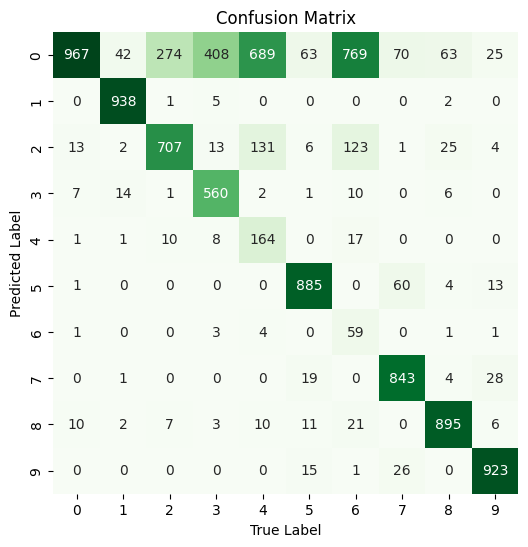

Accuracy:	0.6941

[Class 0]	Precision: 0.9670 | Recall: 0.2869
[Class 1]	Precision: 0.9380 | Recall: 0.9915
[Class 2]	Precision: 0.7070 | Recall: 0.6898
[Class 3]	Precision: 0.5600 | Recall: 0.9318
[Class 4]	Precision: 0.1640 | Recall: 0.8159
[Class 5]	Precision: 0.8850 | Recall: 0.9190
[Class 6]	Precision: 0.0590 | Recall: 0.8551
[Class 7]	Precision: 0.8430 | Recall: 0.9419
[Class 8]	Precision: 0.8950 | Recall: 0.9275
[Class 9]	Precision: 0.9230 | Recall: 0.9565
------------------------------------------

Activation: step, Learning: batch


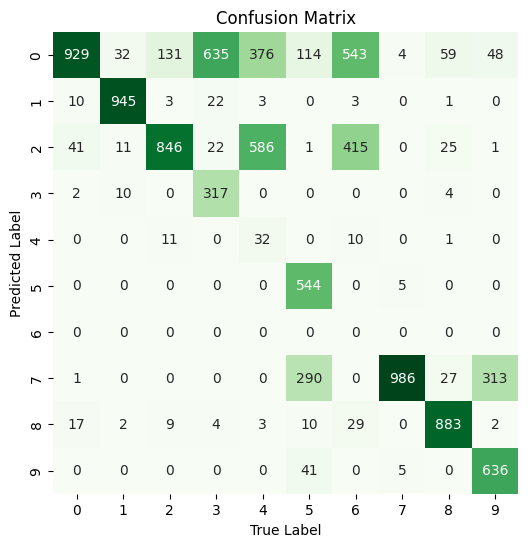

Accuracy:	0.6118

[Class 0]	Precision: 0.9290 | Recall: 0.3236
[Class 1]	Precision: 0.9450 | Recall: 0.9574
[Class 2]	Precision: 0.8460 | Recall: 0.4343
[Class 3]	Precision: 0.3170 | Recall: 0.9520
[Class 4]	Precision: 0.0320 | Recall: 0.5926
[Class 5]	Precision: 0.5440 | Recall: 0.9909
[Class 6]	Precision: 0.0000 | Recall: nan
[Class 7]	Precision: 0.9860 | Recall: 0.6098
[Class 8]	Precision: 0.8830 | Recall: 0.9208
[Class 9]	Precision: 0.6360 | Recall: 0.9326
------------------------------------------

Activation: sigmoid, Learning: online


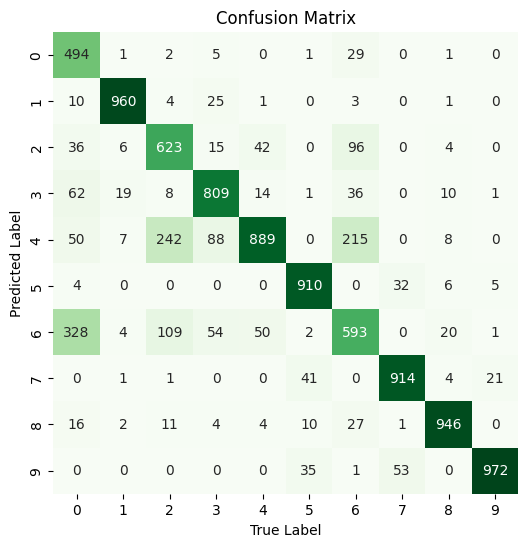

Accuracy:	0.8110

[Class 0]	Precision: 0.4940 | Recall: 0.9268
[Class 1]	Precision: 0.9600 | Recall: 0.9562
[Class 2]	Precision: 0.6230 | Recall: 0.7579
[Class 3]	Precision: 0.8090 | Recall: 0.8427
[Class 4]	Precision: 0.8890 | Recall: 0.5931
[Class 5]	Precision: 0.9100 | Recall: 0.9509
[Class 6]	Precision: 0.5930 | Recall: 0.5108
[Class 7]	Precision: 0.9140 | Recall: 0.9308
[Class 8]	Precision: 0.9460 | Recall: 0.9265
[Class 9]	Precision: 0.9720 | Recall: 0.9161
------------------------------------------

Activation: sigmoid, Learning: batch


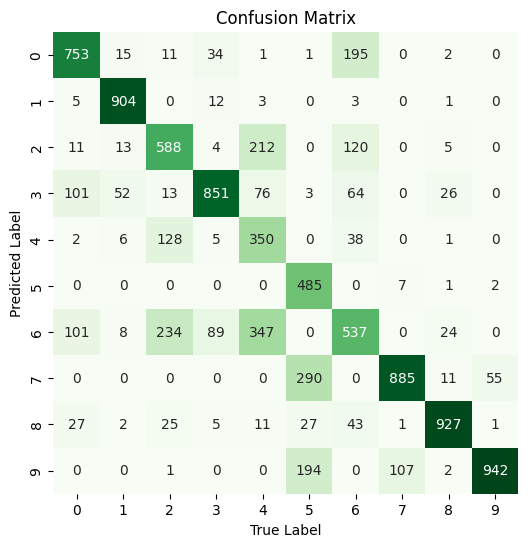

Accuracy:	0.7222

[Class 0]	Precision: 0.7530 | Recall: 0.7441
[Class 1]	Precision: 0.9040 | Recall: 0.9741
[Class 2]	Precision: 0.5880 | Recall: 0.6170
[Class 3]	Precision: 0.8510 | Recall: 0.7175
[Class 4]	Precision: 0.3500 | Recall: 0.6604
[Class 5]	Precision: 0.4850 | Recall: 0.9798
[Class 6]	Precision: 0.5370 | Recall: 0.4007
[Class 7]	Precision: 0.8850 | Recall: 0.7131
[Class 8]	Precision: 0.9270 | Recall: 0.8672
[Class 9]	Precision: 0.9420 | Recall: 0.7560


In [255]:
print('Activation: step, Learning: online')
test_all_perceptrons(step_online_multi, X_test, y_test)
print('------------------------------------------\n')

print('Activation: step, Learning: batch')
test_all_perceptrons(step_batch_multi, X_test, y_test)
print('------------------------------------------\n')

print('Activation: sigmoid, Learning: online')
test_all_perceptrons(sigmoid_online_multi, X_test, y_test)
print('------------------------------------------\n')

print('Activation: sigmoid, Learning: batch')
test_all_perceptrons(sigmoid_batch_multi, X_test, y_test)

#### Preview of predictions 
Print predictions and true labels of test set. Sigmoid/online perceptron is used as it is the best performing model.

In [256]:
n = 30  # First 30 predictions

predictions = np.zeros(n)
for i in range(n):
    outputs = [sigmoid_online_multi[c].do_predict(X_test[i]) for c in range(10)]
    predictions[i] = np.argmax(outputs)  # Pick the perceptron that has the highest confidence level

print(f'Predictions:\t{predictions.astype(int)}')
print(f'True labels:\t{y_test[:n].reshape(1,-1).astype(int)[0]}')

Predictions:	[9 2 1 1 6 1 4 6 5 7 4 5 8 3 4 1 2 4 8 0 2 5 7 9 1 2 6 3 9 4]
True labels:	[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3]


### Analysis  (Multi-class Classification - comparison between 4 perceptron combinations)
- From the testing results, it is clear that the perceptrons using sigmoid activation performed much better than those using step activation.
- The confusion matrices also highlight how the step perceptrons suffer from a different type of misclassifications from the sigmoid perceptrons.
    - The step perceptrons (online and full-batch) have a tendency to misclassify Class 2, 4, and 6 as Class 0 (T-shirts/top) over other classes (high Class 0 False Positive rate). This is probably because many of these items share a similar silhouette and pixels as the T-shirts. To elaborate, the absence of sleeves on the T-shirts would mean that a greater proportion of the pixels would also appear in classes 2, 4, and 6. As a result, many of the long-sleeved T-shirts could be mistaken as short-sleeved T-shirts due to sharing the same perceptron activations for Class 0. This is further exacerbated by the rigid nature of the step function, which could have resulted in it defaulting into the T-shirt class more frequently, rather than outputting a more nuanced confidence level.
    - Meanwhile, the sigmoid perceptrons appear to mix up the instances from Classes 2, 4, and 6 together (high False Positive and False Negative rate for these classes), but do not overclassify instances as Class 0 like the step perceptrons.
- However, the common issue faced by all 4 perceptrons is the difficulty in achieving a decent level of precision and recall for Class 6 (Shirts). Analysing the confusion matrices above, it appears that the perceptrons have a tendency to misclassify Class 6 data instances as Classes 0, 2, and 4, which are the T-shirt/top, Pullover, and Coat classes respectively. Since these 3 classes bear striking visual resemblance to Class 6 Shirts, it is difficult for a single layer perceptron to distinguish between these classes.
- It can also be observed that the batch training also results in slightly worse performance than online training. This is due to the less frequent updates made to the weights, and hence training takes much longer. Given enough iterations, it might be possible for the full-batch training to achieve the same level of performance as the online training.
- Another possible reason why some perceptron classes perform worse than others is that all of them were trained with the same hyperparameters, rather than specifically tailoring the hyperparameters (i.e. learning rate) for each perceptron.

## 1.5. Print weights and Fashion MNIST data

The following cells will print 2 sets of images:

1) Side-by-side of <u>sample data</u> VS <u>weight visualisation</u> of each class (using step/batch weights as they looked the best visually)
2) Side-by-side of <u>online</u> VS <u>full-batch</u> trained weights of Class 0 (T-shirts)

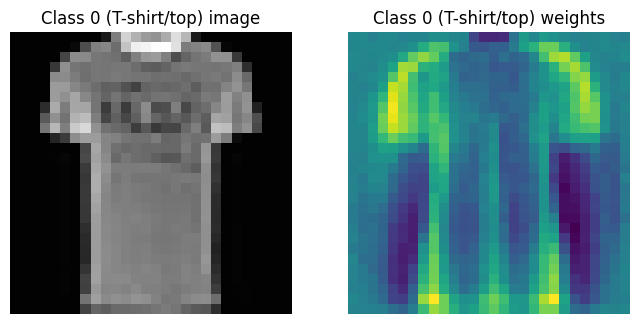

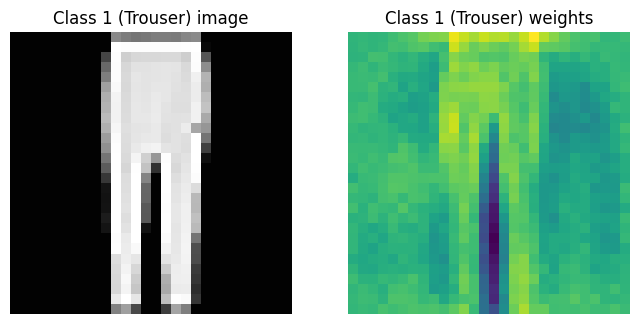

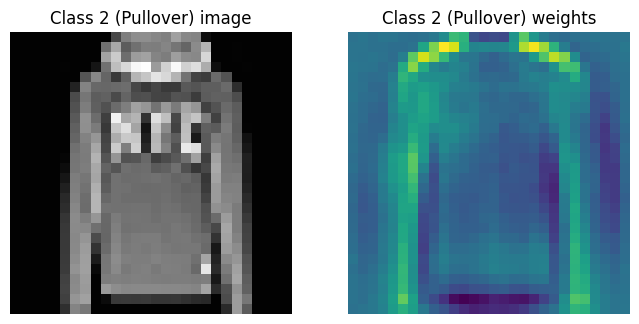

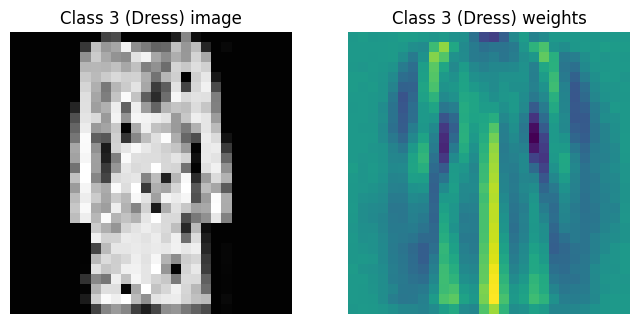

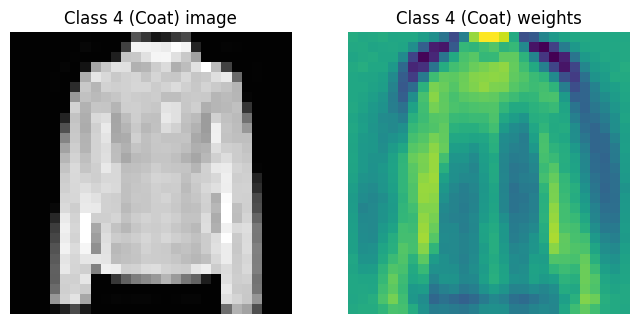

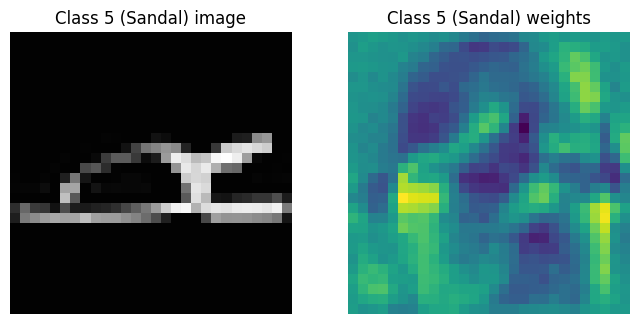

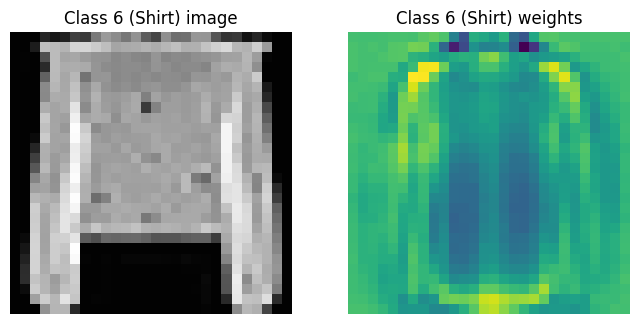

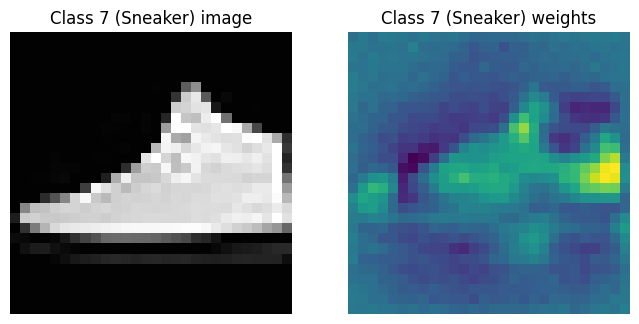

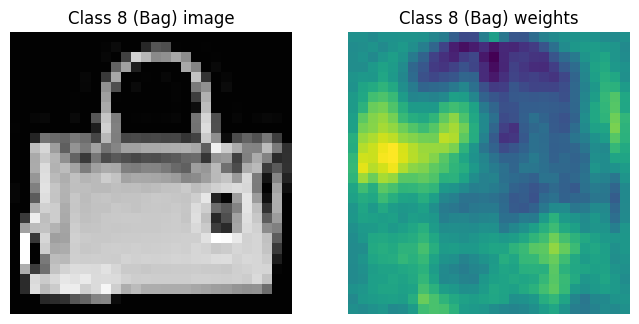

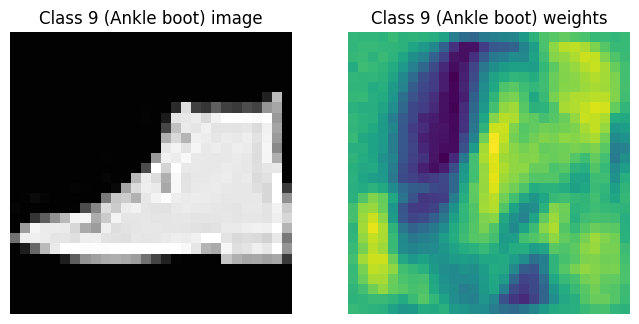

In [257]:
# Weights visualiser (displays 28x28 image of the Perceptron's weights)
def weights_visualiser(weights):
    img = weights[:-1].reshape((28, 28))
    plt.imshow(img, cmap='viridis')

# Data visualiser (displays 28x28 image of the item)
def data_visualiser(image):
    img = image.reshape((28, 28))
    plt.imshow(Image.fromarray(img*255))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    fig = plt.figure(figsize=(8, 4))

    indices = np.where(y_train == i)[0]
    index = np.random.choice(indices)
    plt.subplot(1, 2, 1)
    plt.title(f"Class {i} ({class_names[i]}) image")
    plt.axis("off")
    data_visualiser(X_train[index])

    plt.subplot(1, 2, 2)
    plt.title(f"Class {i} ({class_names[i]}) weights")
    plt.axis("off")
    step_batch_multi[i].weights_visualiser()

    plt.show()

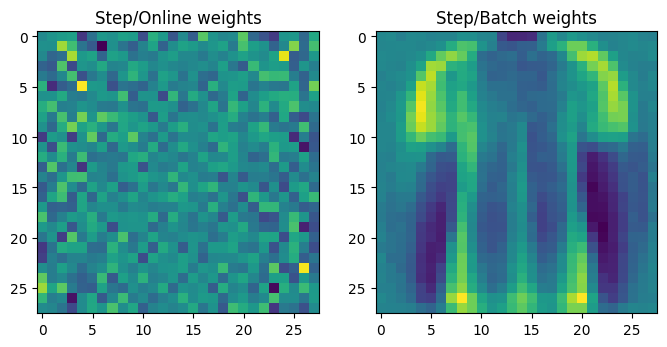

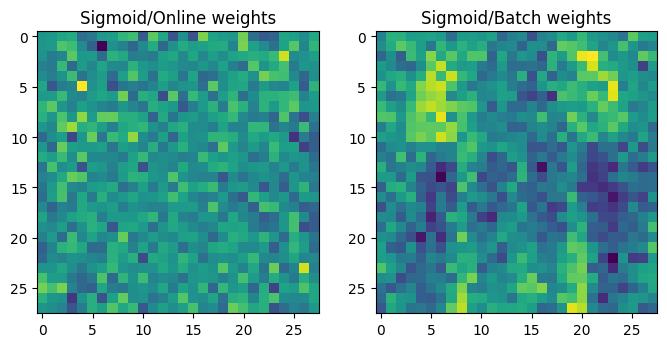

In [258]:
# Visualise clarity of online vs batch weights (step)
fig = plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
step_online_multi[0].weights_visualiser()
plt.title('Step/Online weights')

plt.subplot(1, 2, 2)
step_batch_multi[0].weights_visualiser()
plt.title('Step/Batch weights')
plt.show()

# Visualise clarity of online vs batch weights (sigmoid)
fig = plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sigmoid_online_multi[0].weights_visualiser()
plt.title('Sigmoid/Online weights')

plt.subplot(1, 2, 2)
sigmoid_batch_multi[0].weights_visualiser()
plt.title('Sigmoid/Batch weights')
plt.show()

### Analysis:
- It can be observed that in each of the classes, the weight visualisations bear close resemblance to the corresponding clothing/shoe items. It can be noted that the silhouette 'lights up' at the parts that are unique or strongly correspond to the item's generic shape. For example, the T-shirt weights have a distinct torso shape, while the shoe weights are shaped like a foot.
- It is also interesting to note how the dark shadows in the weight visualisations are also shaped in the classes that do not correspond to the perceptron. For example, the weight visualisation for Class 8 (bag) contain both shirt and shoe-shaped shadows. This might mean that the perceptron has learned to clearly distinguish which items are not from the class it belongs to.
- This suggests that the perceptron weights get more activated when the pixel it corresponds to appears more often in the picture.
- Additionally, it was interesting to note that the weight visualisations appeared more blurry for the online-trained perceptrons, even though they achieved a much higher accuracy score. This could be due to the stochastic manner the weights get updated, which is less stable than taking the average weight updates of all the training data for each epoch in full-batch training. On the other hand, the full-batch perceptrons take the mean updates of the entire batch, which resulted in a smoother and more general-looking silhouette that is visually representative of the entire class as a whole.